In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from eli5.sklearn import PermutationImportance
import xgbfir
from boruta import BorutaPy
from sklearn.metrics import mean_squared_error
import pickle
%matplotlib inline

In [2]:
SEED = 21

In [3]:
train = pd.read_feather("transform/train_transform_after_preparation.feather")
pred = pd.read_feather("transform/test_transform_after_preparation.feather")

In [4]:
train.shape

(1456, 346)

In [5]:
pred.shape

(1459, 345)

In [6]:
train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,65.0,8450,7,5,7,7,196.0,706,...,0,0,1,0,0,0,0,1,0,208500
1,2,20,80.0,9600,6,8,34,34,0.0,978,...,0,0,1,0,0,0,0,1,0,181500
2,3,60,68.0,11250,7,5,9,8,162.0,486,...,0,0,1,0,0,0,0,1,0,223500
3,4,70,60.0,9550,7,5,95,40,0.0,216,...,0,0,1,1,0,0,0,0,0,140000
4,5,60,84.0,14260,8,5,10,10,350.0,655,...,0,0,1,0,0,0,0,1,0,250000


In [7]:
X_train = train.drop(['SalePrice', 'Id'], 1)
y_train = np.log1p(train['SalePrice'])

/tmp/ipykernel_7539/2050573941.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = train.drop(['SalePrice', 'Id'], 1)


# Recursive feature elimination

In [16]:
lgbEst = LGBMRegressor()

In [17]:
min_features_to_select = 30  # Minimum number of features to consider
rfecv = RFECV(estimator=lgbEst, step=1, cv=10, n_jobs=-1,
              scoring='neg_mean_squared_error',
              min_features_to_select=min_features_to_select)

In [18]:
rfecv.fit(X_train, y_train)

/home/roma/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


RFECV(cv=10, estimator=LGBMRegressor(), min_features_to_select=30, n_jobs=-1,
      scoring='neg_mean_squared_error')

In [19]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 103


In [20]:
rfecv_train_features = rfecv.get_feature_names_out()
rfecv_pred_features = rfecv.get_feature_names_out()

In [21]:
#rfecv_train_features = np.append(rfecv_train_features, ['SalePrice', 'Id'])

In [22]:
rfecv_train_features.shape

(103,)

In [23]:
rfecv_train_features

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'MoSold', 'YrSold', 'BsmtQualnum',
       'ExterCondnum', 'ExterQualnum', 'KitchenQualnum', 'FireplaceQunum',
       'HeatingQCnum', 'BsmtFinType1num', 'BsmtExposurenum',
       'OverallGrade', 'GarageGrade', 'ExterGrade', 'KitchenScore',
       'FireplaceScore', 'GarageScore', 'SimplOverallGrade',
       'SimplGarageScore', 'TotalBath', 'AllSF', 'AllFlrsSF',
       'AllPorchSF', 'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_IR1', 'LotShape_Reg', 'LandContour_Lvl',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_Inside',
       'Neig

### Save features

In [24]:
pkl_filename = "feature_selection/rfecv_train_features.pkl"
with open(pkl_filename, 'wb') as f:
    pickle.dump(rfecv_train_features, f)

# Shuffle target permutation

In [25]:
def get_feature_importances(X, y, shuffle, seed=None):
    train_features = [f for f in X]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    if shuffle:
        y = y.copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    lgb_params = {
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4,
        'importance_type': 'gain'
    }
    
    # Fit the model
    clf = LGBMRegressor(**lgb_params, num_boost_round=200)
    clf.fit(X, y)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importances_
    imp_df['trn_score'] = mean_squared_error(y, clf.predict(X_train))
    
    return imp_df

In [26]:
actual_imp_df = get_feature_importances(X_train, y_train, shuffle=False, seed=SEED)

/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [27]:
actual_imp_df.head()

,feature,importance_gain,trn_score
0,MSSubClass,5.836760,0.01738
1,LotFrontage,6.326601,0.01738
2,LotArea,68.490068,0.01738
3,OverallQual,9801.974420,0.01738
4,OverallCond,16.238576,0.01738


In [29]:
null_imp_df = pd.DataFrame()
nb_runs = 200
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(X_train, y_train, shuffle=False)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Done with    1 of  200 (Spent   0.0 min)

/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Done with    2 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with    3 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with    4 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with    5 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with    6 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with    7 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with    8 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with    9 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   10 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   11 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   12 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   13 of  200 (Spent   0.0 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   14 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   15 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   16 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   17 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   18 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   19 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   20 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   21 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   22 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   23 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   24 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   25 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   26 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   27 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   28 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   29 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   30 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   31 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   32 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   33 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   34 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   35 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   36 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   37 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   38 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   39 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   40 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   41 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   42 of  200 (Spent   0.1 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   43 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   44 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   45 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   46 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   47 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   48 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   49 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   50 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   51 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   52 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   53 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   54 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   55 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   56 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   57 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   58 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   59 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   60 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   61 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   62 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   63 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   64 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   65 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   66 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   67 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   68 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   69 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   70 of  200 (Spent   0.2 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   71 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   72 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   73 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   74 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   75 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   76 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   77 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   78 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   79 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   80 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   81 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   82 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   83 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   84 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   85 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   86 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   87 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   88 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   89 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   90 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   91 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   92 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   93 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   94 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   95 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   96 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   97 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   98 of  200 (Spent   0.3 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with   99 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  100 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  101 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  102 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  103 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  104 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  105 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  106 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  107 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  108 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  109 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  110 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  111 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  112 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  113 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  114 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  115 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  116 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  117 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  118 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  119 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  120 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  121 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  122 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  123 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  124 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  125 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  126 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  127 of  200 (Spent   0.4 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  128 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  129 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  130 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  131 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  132 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  133 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  134 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  135 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  136 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  137 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  138 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  139 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  140 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  141 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  142 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  143 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  144 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  145 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  146 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  147 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  148 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  149 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  150 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  151 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  152 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  153 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  154 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  155 of  200 (Spent   0.5 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  156 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  157 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  158 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  159 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  160 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  161 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  162 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  163 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  164 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  165 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  166 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  167 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  168 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  169 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  170 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  171 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  172 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  173 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  174 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  175 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  176 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  177 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  178 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  179 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  180 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  181 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  182 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  183 of  200 (Spent   0.6 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  184 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  185 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  186 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  187 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  188 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  189 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  190 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  191 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  192 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  193 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  194 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  195 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  196 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  197 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  198 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  199 of  200 (Spent   0.7 min)[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/home/roma/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Done with  200 of  200 (Spent   0.7 min)

In [30]:
null_imp_df.head()

,feature,importance_gain,trn_score,run
0,MSSubClass,12.183496,0.017225,1
1,LotFrontage,8.414283,0.017225,1
2,LotArea,71.259720,0.017225,1
3,OverallQual,10097.599078,0.017225,1
4,OverallCond,17.801975,0.017225,1


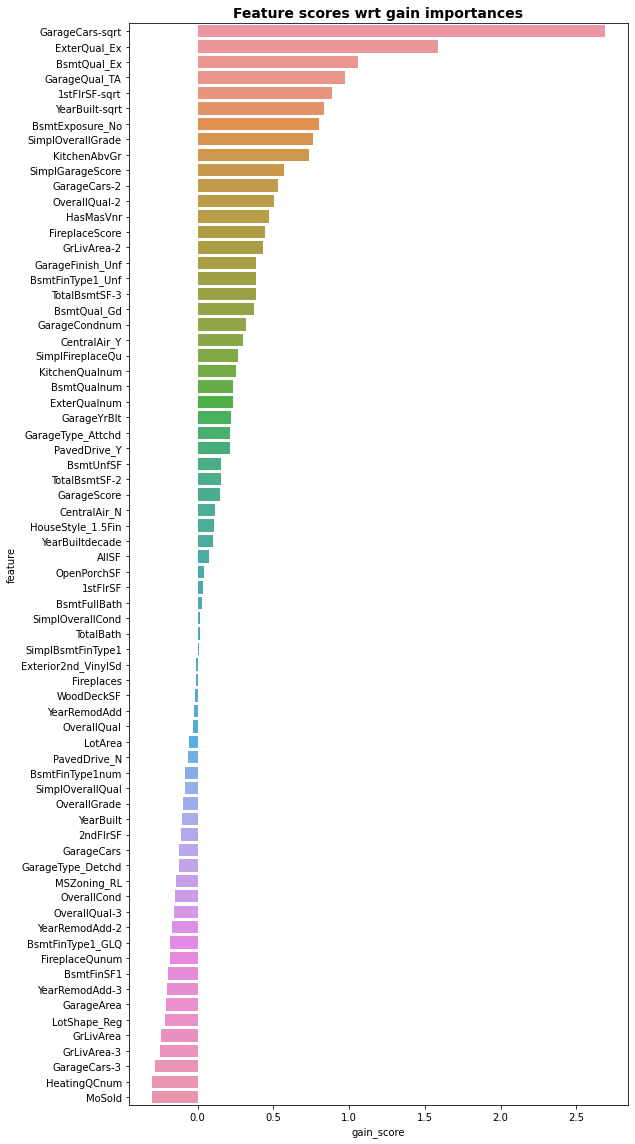

In [31]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

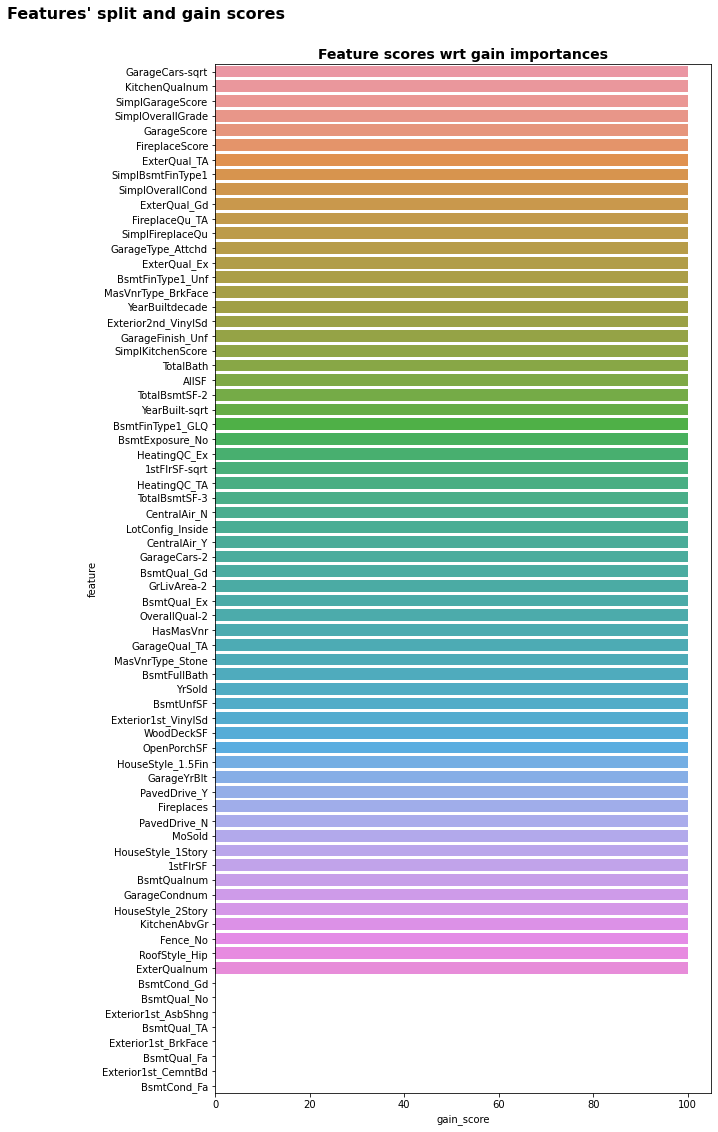

In [32]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [33]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

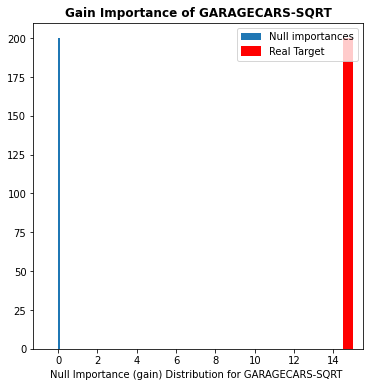

In [34]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='GarageCars-sqrt')

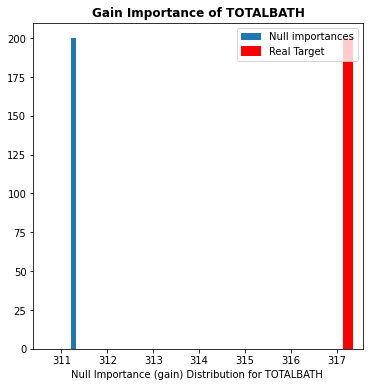

In [35]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='TotalBath')

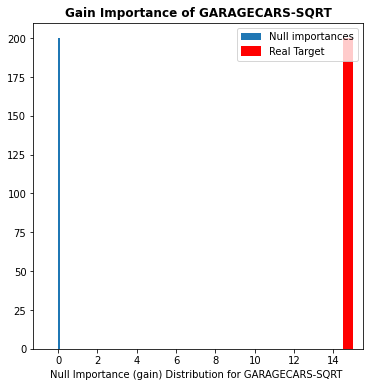

In [36]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='GarageCars-sqrt')

In [37]:
corr_scores_df[corr_scores_df['gain_score']==100]['feature'].to_numpy()

array(['BsmtUnfSF', '1stFlrSF', 'BsmtFullBath', 'KitchenAbvGr',
       'Fireplaces', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'MoSold',
       'YrSold', 'BsmtQualnum', 'ExterQualnum', 'GarageCondnum',
       'KitchenQualnum', 'YearBuiltdecade', 'SimplFireplaceQu',
       'SimplOverallCond', 'SimplBsmtFinType1', 'FireplaceScore',
       'GarageScore', 'SimplOverallGrade', 'SimplGarageScore',
       'SimplKitchenScore', 'TotalBath', 'AllSF', 'HasMasVnr',
       'OverallQual-2', 'GrLivArea-2', 'GarageCars-2', 'GarageCars-sqrt',
       'TotalBsmtSF-2', 'TotalBsmtSF-3', '1stFlrSF-sqrt',
       'YearBuilt-sqrt', 'LotConfig_Inside', 'HouseStyle_1.5Fin',
       'HouseStyle_1Story', 'HouseStyle_2Story', 'RoofStyle_Hip',
       'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'MasVnrType_BrkFace',
       'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA',
       'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtExposure_No',
       'BsmtFinType1_GLQ', 'BsmtFinType1_Unf', 'HeatingQC_Ex',
       

In [38]:
target_permutation_train_features = corr_scores_df[corr_scores_df['gain_score']==100]['feature'].to_numpy()
target_permutation_pred_features = corr_scores_df[corr_scores_df['gain_score']==100]['feature'].to_numpy()
#target_permutation_train_features = np.append(target_permutation_train_features, ['SalePrice', 'Id'])
#target_permutation_pred_features = np.append(target_permutation_train_features, ['Id'])

### Save features

In [39]:
pkl_filename = "feature_selection/target_permutation_train_features.pkl"
with open(pkl_filename, 'wb') as f:
    pickle.dump(target_permutation_train_features, f)

# Boruta

In [40]:
#lgbEst_boruta = LGBMRegressor(num_boost_round=100)
lgbEst_boruta = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=SEED)

In [41]:
boruta_selector = BorutaPy(lgbEst_boruta, n_estimators='auto', verbose=2, random_state=SEED)

In [42]:
boruta_selector.fit(X_train.to_numpy(), y_train.to_numpy())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	344
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	344
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	344
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	344
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	344
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	344
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	344
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	55
Rejected: 	289
Iteration: 	9 / 100
Confirmed: 	26
Tentative: 	29
Rejected: 	289
Iteration: 	10 / 100
Confirmed: 	26
Tentative: 	29
Rejected: 	289
Iteration: 	11 / 100
Confirmed: 	26
Tentative: 	29
Rejected: 	289
Iteration: 	12 / 100
Confirmed: 	26
Tentative: 	24
Rejected: 	294
Iteration: 	13 / 100
Confirmed: 	26
Tentative: 	24
Rejected: 	294
Iteration: 	14 / 100
Confirmed: 	26
Tentative: 	24
Rejected: 	294
Iteration: 	15 / 100
Confirmed: 	26
Tentative: 	24
Rejected: 	294
Iteration: 	16 / 100
Confirmed: 	2

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=185,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7FBE088B1240),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FBE088B1240, verbose=2)

In [43]:
boruta_train_features = X_train.iloc[:, boruta_selector.support_].columns
boruta_pred_features = X_train.iloc[:, boruta_selector.support_].columns

In [44]:
#boruta_train_features = np.append(boruta_train_features, ['SalePrice', 'Id'])

In [45]:
boruta_train_features.shape

(33,)

In [46]:
boruta_train_features

Index(['LotArea', 'OverallQual', 'YearBuilt', 'BsmtFinSF1', 'GarageCars',
       'BsmtQualnum', 'KitchenQualnum', 'FireplaceQunum', 'BsmtFinType1num',
       'SimplOverallQual', 'OverallGrade', 'GarageGrade', 'FireplaceScore',
       'GarageScore', 'SimplOverallGrade', 'SimplGarageScore', 'TotalBath',
       'AllSF', 'AllFlrsSF', 'OverallQual-2', 'OverallQual-3',
       'OverallQual-sqrt', 'GarageCars-2', 'GarageCars-3', 'GarageCars-sqrt',
       'YearBuilt-2', 'YearBuilt-3', 'YearBuilt-sqrt', 'MSZoning_C (all)',
       'MSZoning_RM', 'CentralAir_N', 'CentralAir_Y', 'GarageType_Detchd'],
      dtype='object')

### Save features

In [47]:
pkl_filename = "feature_selection/boruta_train_features.pkl"
with open(pkl_filename, 'wb') as f:
    pickle.dump(boruta_train_features, f)

# Shuffle feature permutation

In [13]:
#lgbEst_feature_perm = LGBMRegressor()
#lgbEst_feature_perm = RandomForestRegressor()

In [17]:
feature_perm = PermutationImportance(lgbEst_feature_perm,scoring='neg_mean_squared_error', n_iter=10, cv=5, random_state=SEED)

In [18]:
min_features_to_select = 50  # Minimum number of features to consider
sel_perm_rfecv = RFECV(estimator=feature_perm,
                       step=1, cv=5, n_jobs=-1,
              scoring='neg_mean_squared_error',
              min_features_to_select=min_features_to_select)

In [19]:
sel_perm_rfecv.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print("Optimal number of features : %d" % sel_perm_rfecv.n_features_)

In [ ]:
X_feature_perm = X_train[sel_perm_rfecv.get_feature_names_out()]

In [ ]:
X_feature_perm.head()

In [ ]:
X_feature_perm.shape